In [3]:
import re 
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Training my own Classifier

## Preprocessing

In [4]:
train_data = pd.read_csv('train.csv')

In [5]:
train_data.head()

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


## Cleaning

#### -Dropping Rows with Null Values

In [6]:
train_data.dropna(subset=['text'], inplace=True)

#### -Remove Punctuation

In [5]:
#use regular expression, re.sub() returns a string/row that is not '\w', '\s', as 
#the symbol '^' is the negation.
train_data.text = train_data.text.apply(lambda x: re.sub(r'[^\w\s]', '', x) )

#### -Remove Stopwords

In [6]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english') #specify the language and get the stopwords in that language

#going through each of the text and removing any words that is in stopwords
train_data.text = train_data.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

#### -Removing Link

In [7]:
train_data.text = train_data.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))

### Normalising Words

In [8]:
#basically, normalise the words which means words that are similar and have similar
#meaning will be treated as the same word.
#from nltk.stem import PorterStemmer
#porter_stemmer = PorterStemmer() #Steming is choping off the words to the original word/common word

#### -Normalising Words using Lemmatization

In [9]:
lemmatizer = nltk.WordNetLemmatizer() #Lemmatization will look at the words and
                                        #try to find the base form of the words
train_data.text = train_data.text.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

#### -Removing the remaining Null rows after cleaning

In [10]:
train_data.dropna(subset=['text'], inplace=True)
train_data = train_data[train_data.text != ''] #only include rows that is not empty

## Data Exploration

In [11]:
train_data.head()

,textID,text,sentiment
0,cb774db0d1,Id responded going,neutral
1,549e992a42,Sooo SAD miss San Diego,negative
2,088c60f138,bos bullying,negative
3,9642c003ef,interview leave alone,negative
4,358bd9e861,Sons couldnt put release already bought,negative


### Wordcloud

In [12]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text_string= train_data.iloc[:,:].text.str.cat(sep='. ')

In [13]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

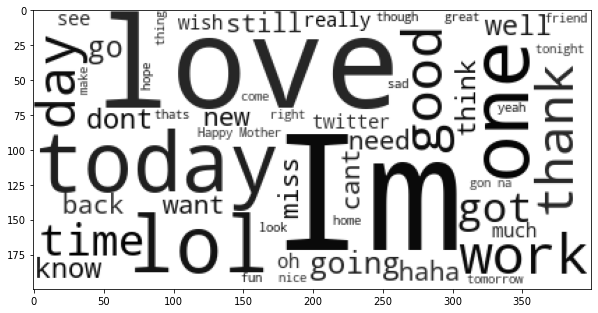

In [14]:
stp = STOPWORDS.copy()
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# generate word cloud
wc.generate(text_string)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

## Initialise Data Training

### Training a naive bayes Sentiment Classifier using sklearn

In [15]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer #, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB #, GaussianNB
#from sklearn import metrics
#import numpy as np

#### -Create a feature matrix for machine learning

In [16]:
#CountVectorizer() function creates a feature matrix,
#transforming text into some training matrix which is used for machine learning.
#Each column/word will be a feature. If the word is present in the row, that feature
#column will have a value of 1.
vectorizer = CountVectorizer()

In [17]:
train_data.dropna(subset=['text'], inplace=True)
train_x = vectorizer.fit_transform(train_data.text)
#print(pd.DataFrame(train_x.A, columns=vectorizer.get_feature_names()).to_string())

#### -MultinomialNB model

In [20]:
nb = MultinomialNB()

#fitting the model, fitting train_X (x value) with training_set.sentiment (Y value)
#which is learning from the train set so when testing, we have to create the exact same feature matrix
#so the model can recognise it and generate predictions for it.
nb.fit(train_x, train_data.sentiment)

# use metrics.accuracy_score(y_true, y_pred) to see what's the accuracy is

MultinomialNB()

# 2. Using my Classifier on the Test data 

### Loading and Cleaning the testing dataset

In [22]:
testing_data = pd.read_csv('test.csv')

In [23]:
#Droping null texts
testing_data.dropna(subset=['text'], inplace=True)

In [24]:
#Removing punctuations and symbols
testing_data.text = testing_data.text.apply(lambda x: re.sub(r'[^\w\s]', '', x) )

In [25]:
#Removing stopwords
testing_data.text = testing_data.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

In [26]:
#Removing links
testing_data.text = testing_data.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))

In [27]:
#Lemmatization and Tokenizing
testing_data.text = testing_data.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

In [28]:
#Removing the remaining Null rows, after preprocessing
testing_data.dropna(subset=['text'], inplace=True)
testing_data.head()

,textID,text
0,f87dea47db,Last session day
1,96d74cb729,Shanghai also really exciting precisely skyscr...
2,eee518ae67,Recession hit Veronique Branquinho quit compan...
3,01082688c6,happy bday
4,33987a8ee5,like


In [29]:
#vectorizing the test's texts 
test_x = vectorizer.transform(testing_data.text)

### Prediction from the Trained Model

In [34]:
predicted = nb.predict(test_x)

In [35]:
prediction_data = pd.read_csv('test.csv')

In [36]:
prediction_data = prediction_data.assign(sentiment = predicted)

### Output

In [37]:
kaggle_result = prediction_data.drop('text', axis=1)

In [38]:
#Output to a Comma Separated Variables file.
kaggle_result.to_csv('Kaggle_result.csv',index=False)